# Querying the OpenAlex data for works from Japan

Our questions are:
1. How many sources of scholarly works are in Japan?
2. What are the types of these sources? Journals? Repositories? Conferences?
    - For journals, what are the publishers?
    - For repositories, what are the host institutions?
3. What are the names of these sources?
4. How many works have Japanese sources? How does this vary over time?


In [1]:
import requests

### Question 1: How many sources of scholarly works are in Japan?

Let's start with the first question: How many sources of scholarly works are in Japan?

To do this, we will query the `/sources` API endpoint, and use a **filter** to limit it to sources where the `country_code` is `JP`.

In [2]:
country_code = 'JP'
url = f"https://api.openalex.org/sources"
params = {
    'filter': f'country_code:{country_code}',
}
r = requests.get(url, params=params)
num_sources = r.json()['meta']['count']
print(f"There are {num_sources} sources with country_code 'JP' (Japan)")

There are 2162 sources with country_code 'JP' (Japan)


### Question 2: What are the types of these sources?
The next question is: What are the *types* of these sources. Possible types are listed in the API docs on the [Source object](https://docs.openalex.org/api-entities/venues/venue-object#type): `journal`, `repository`, `conference`, `ebook platform`.

To answer this question, we can add a `group_by` to our API query, grouping by the `type` field and counting the number of sources:

In [3]:
params = {
    'filter': f'country_code:{country_code}',
    'group_by': 'type',
}
r = requests.get(url, params=params)
print("Number of sources in Japan for each *type* of source:")
for item in r.json()['group_by']:
    print(f'  "{item["key"]}": {item["count"]} sources')

Number of sources in Japan for each *type* of source:
  "journal": 2162 sources


All of the Japanese sources are of type: `journal`. We are not seeing any of the other types of sources.

It's unclear why this is the case. It might be true that there actually are no Japanese repositories or conferences that belong in OpenAlex, or maybe they just aren't labeled with Japan's country code. This would be interesting to look into further. For now, though, let's set that aside and continue answering our questions.

### Question 3: What are the names of these sources?
The next question is: What are the *names* of these sources?

To answer this, we need the API to give us all 2,162 sources. This means we will need to use the [paging technique](https://docs.openalex.org/how-to-use-the-api/get-lists-of-entities/paging).

We'll adapt the technique from the [paging notebook](../getting-started/paging.ipynb) to collect the names and ISSNs of the sources.

In [4]:
# page through to get all sources
# use paging technique from `paging.ipynb`
# url with a placeholder for page number
country_code = 'JP'
url = f"https://api.openalex.org/sources"
params = {
    'filter': f'country_code:{country_code}',
    'page': 1,  # initaliaze `page` param to 1
}

has_more_pages = True
fewer_than_10k_results = True

# We will collect the data in a variable called `japanese_sources`.
# Initialize this as an empty list, which we will append to
japanese_sources = []

# loop through pages
loop_index = 0
while has_more_pages and fewer_than_10k_results:
    
    page_with_results = requests.get(url, params=params).json()
    
    # loop through partial list of results
    results = page_with_results['results']
    for api_result in results:
        # # Collect the fields we are interested in, for this source
        # source = {field: api_result[field] for field in fields}
        # Append this source to our `japanese_sources` list
        japanese_sources.append(api_result)

    # next page
    params['page'] += 1
    
    # end loop when either there are no more results on the requested page 
    # or the next request would exceed 10,000 results
    per_page = page_with_results['meta']['per_page']
    has_more_pages = len(results) == per_page
    fewer_than_10k_results = per_page * params['page'] <= 10000
    loop_index += 1
print(f"collected {len(japanese_sources)} sources (using {loop_index+1} api calls)")

collected 2162 sources (using 88 api calls)


Now would be a good time for us to put our sources into a Pandas dataframe. This is just a way to organize the data, make it more spreadsheet-like, and make it more convenient to work with.

In [5]:
import pandas as pd

# Each source in our list of `japanese sources` contains a lot of data, some of it complex and nested.
# So let's limit our dataframe to include only some of the fields.

# Define the fields that we are interested in collecting:
fields = [
    'id',
    'issn_l',
    'display_name',
    'host_organization',
    'works_count',
    'cited_by_count',
    'type',
]

# One way to limit the dataframe to include only our `fields` is to use the `from_records()` method
# and specify only the columns we want.
df_sources = pd.DataFrame.from_records(japanese_sources, columns=fields)

num_rows, num_columns = df_sources.shape
print(f"Dataframe has {num_rows} rows and {num_columns} columns.")
print()  # blank line
print("The first five sources are named:")
for name in df_sources['display_name'].head(5):
    print(f"  {name}")

Dataframe has 2162 rows and 7 columns.

The first five sources are named:
  Journal of the Japan Society of Mechanical Engineers
  Nippon Hoshasen Gijutsu Gakkai Zasshi
  Journal of the Physical Society of Japan
  Nihon rinsho. Japanese journal of clinical medicine
  Bulletin of the Chemical Society of Japan


With Pandas, it is very easy to save the data as a spreadsheet file, in case we want to work with it later.

In [6]:
df_sources.to_csv("japan_sources.csv")

At this point, we can go back and answer a question we skipped over when we moved onto question 3: What are the [`host_organizations`](https://docs.openalex.org/api-entities/venues/venue-object#host_organization) for these sources? In the case of a source of type `journal`, a `host_organization` is a Publisher---the company or organization that distributes the works.

The data we have collected from the API contains the field `host_organization`, which is a link that can be fed back into the API to get more information about the organization, such as name, parent companies, and number of works. It would not be hard to collect this data, but for now we will leave it to future work. However, we can use the data we already have to simply *count* the number of different publishers that host japanese sources.

In [7]:
num_host_orgs = df_sources['host_organization'].nunique()
print(f"The Japanese sources are associated with {num_host_orgs} different host organizations (publishers).")

The Japanese sources are associated with 228 different host organizations (publishers).


### Question 4: How many works have Japanese sources? How does this vary over time?
Finally, let's look at how many works there are with Japanese sources, and the trends of these works over time.

First, we'll just look at the number of works with Japanese sources in the OpenAlex dataset.

In [8]:
num_works = df_sources['works_count'].sum()
print(f"There are {num_works:,} works (articles) with Japanese sources.")  # putting ":," after num_works tells the formatter to use commas as thousands separators

There are 3,716,278 works (articles) with Japanese sources.


Next, we'll look at the number of works per year per source. This data is not in our dataframe (we excluded it when we specified only certain `fields`). However, we can go back to our collection of `japanese_sources`, which has the field `counts_by_year`. This field—as we can learn from [the docs](https://docs.openalex.org/api-entities/venues/venue-object#counts_by_year)—contains the source's counts of works by year, for the last ten years, organized as a list of dictionaries.

In [9]:
# Put the data for `counts_by_year` into a Pandas dataframe.
data = []
for source in japanese_sources:
    for year_count in source['counts_by_year']:
        data.append({
            'id': source['id'],
            'year': int(year_count['year']),
            'works_count': int(year_count['works_count']),
            'cited_by_count': int(year_count['cited_by_count']),
        })
df_counts_by_year = pd.DataFrame(data)

# Each row in the dataframe represents one year of one source.
# We can group by year and sum the number of works to get the
# total counts by year.

all_counts_japan = df_counts_by_year.groupby('year')['works_count'].sum()
print(f"Created a dataframe counting works from year {all_counts_japan.index.min()} to year {all_counts_japan.index.max()}.")

Created a dataframe counting works from year 2012 to year 2023.


We'll use the [seaborn](https://seaborn.pydata.org/index.html) library to plot graphs of the data. Seaborn is an extension on top of [matplotlib](https://seaborn.pydata.org/index.html), the standard visualization library in Python. It is not the only choice for visualization, but we'll use it now because it is widely-used, and not too difficult to get started with.

Text(0.5, 1.0, 'Number of works in Japanese journals')

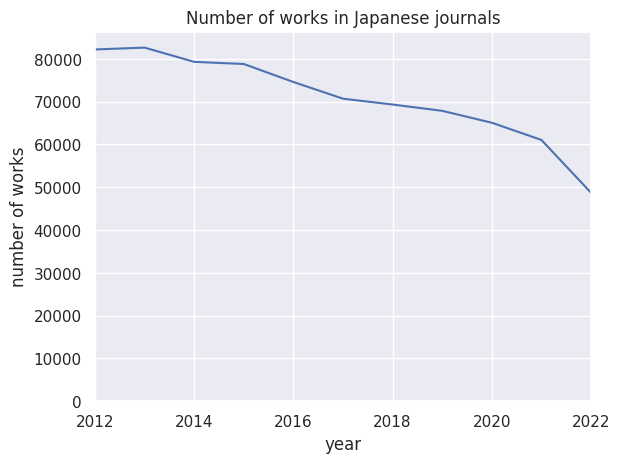

In [10]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Visualize the data
g = sns.lineplot(all_counts_japan)
g.set_ylim(bottom=0)
g.set_xlim(2012, 2022)
g.set_ylabel("number of works")
g.set_title("Number of works in Japanese journals")

We have shown the number of works with Japanese sources in absolute terms, and that the number has been declining over recent years. But this only tells part of the story. Is this a general trend in the data set, or is it specific to Japanese works? To answer this, we want to look at the *relative* number of works, as a percentage of total number of works published in journals.

We need to get the total number of works by year. One way to do this is to query the `/works` API endpoint, and [group by](https://docs.openalex.org/api-entities/works/group-works) the `publication_year`. To match the data we have about sources in Japan, we'll also limit the data to the last ten years, using the [`from_publication_date` convenience filter](https://docs.openalex.org/api-entities/works/filter-works#from_publication_date).

In [11]:
url = f"https://api.openalex.org/works"
filters = [
    'primary_location.source.type:journal',
    'from_publication_date:2012-01-01',
]
params = {
    'filter': ",".join(filters),
    'group_by': 'publication_year',
}
# make the API query
r = requests.get(url, params=params)

# Get the data into a pandas dataframe
counts_data = []
for row in r.json()['group_by']:
    counts_data.append({
        'year': int(row['key']),
        'works_count': int(row['count']),
    })
all_counts_all_countries = pd.DataFrame(counts_data)
# change the data into a series, with the year as index and the number of works as values.
# this will match the `all_counts_japan` data
all_counts_all_countries = all_counts_all_countries.set_index('year')['works_count']

Text(0, 0.5, 'Relative number of works')

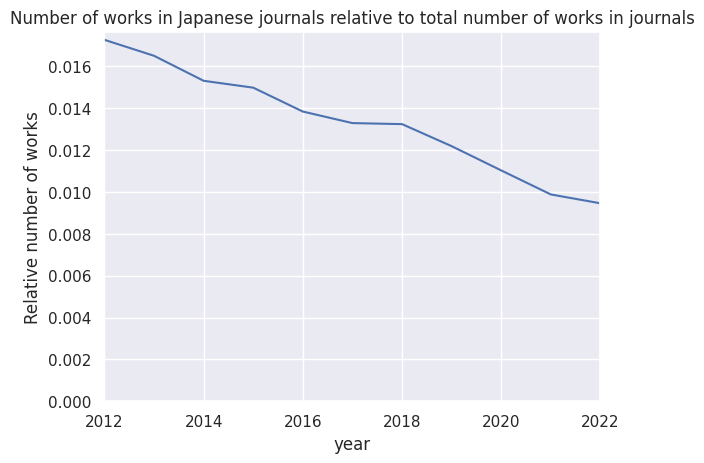

In [12]:
relative_japan = all_counts_japan / all_counts_all_countries
g = sns.lineplot(relative_japan)
g.set_ylim(bottom=0)
g.set_xlim(2012, 2022)
g.set_title("Number of works in Japanese journals relative to total number of works in journals")
g.set_ylabel("Relative number of works")

We have shown that the relative number of works with Japanese sources has been declining over the last ten years. One possible explanation for this is that Japanese authors are publishing less in Japanese sources. Our next step could be to look at papers with Japanese *authors* (institutional affiliations in Japan), and see if they are increasingly publishing in non-Japanese sources. Looking at publications by language would also be interesting—this information is not directly available in OpenAlex yet, but it would be possible to get it ourselves.